###  Windowed time lagged cross correlations (WTLCC)

<p>
To assess the more fine grained dynamics, we can compute the windowed time lagged cross correlations (WTLCC). This process repeats the time lagged cross correlation in multiple windows of the signal. Then we can analyze each window or take the sum over the windows would provide a score comparing the difference between the leader follower interaction between two individuals.    
</p>    

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
import datetime
import geopandas as gpd
import folium
import time
import my_code
warnings.filterwarnings('ignore')

import seaborn as sns

In [3]:
data = pd.read_csv('/Users/alket/desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)
agg_by_cell_day = data.groupby(by = ['date','cell_num'])

In [4]:
dict2data = {}
count = 0
for i,k in agg_by_cell_day:
    count +=1
    if count >221: break
    dict2data[i] = k

In [5]:
c1 = dict2data['2017-04-16','495-1267']
c2 = dict2data['2017-04-16','496-1256']
c1

,date,cell_num,nr_people,hours,minutes
168,2017-04-16,495-1267,330.0,0.0,0.0
389,2017-04-16,495-1267,335.0,0.0,15.0
610,2017-04-16,495-1267,333.0,0.0,30.0
831,2017-04-16,495-1267,331.0,0.0,45.0
1052,2017-04-16,495-1267,330.0,1.0,0.0
...,...,...,...,...,...
20279,2017-04-16,495-1267,304.0,22.0,45.0
20500,2017-04-16,495-1267,309.0,23.0,0.0
20721,2017-04-16,495-1267,309.0,23.0,15.0
20942,2017-04-16,495-1267,311.0,23.0,30.0


In [6]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [7]:
agg_by_cell = data.groupby(by = ['cell_num'])
cc1 = agg_by_cell.get_group('495-1267')
cc2 = agg_by_cell.get_group('495-1258')

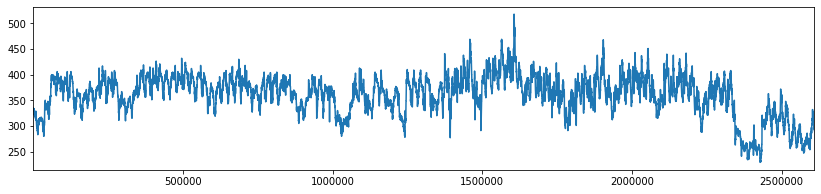

In [8]:
s = c1['nr_people'].reset_index(drop=True)
plt.figure(figsize=(14, 3))
cc1['nr_people'].plot()
plt.show()

3
samples per split  32.0


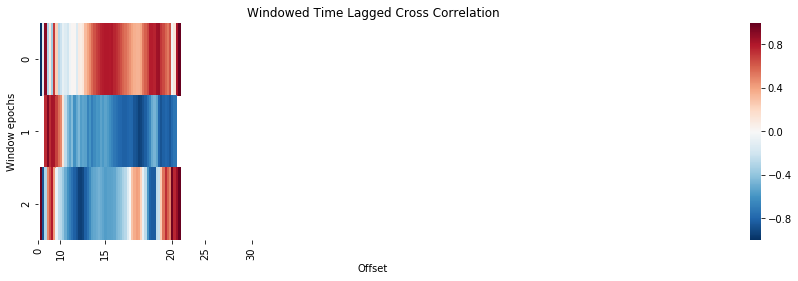

In [37]:
# Windowed time lagged cross correlation
#seconds = 3
#fps =3
window = 32
no_splits = int(96/window)
print(no_splits)
samples_per_split = c1.shape[0]/no_splits
print('samples per split ', samples_per_split)
rss=[]
for t in range(0, no_splits):
    
    d1 = cc1['nr_people'].reset_index(drop=True)
    d2 = cc2['nr_people'].reset_index(drop=True)
  
    d1 = d1.loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = d2.loc[(t)*samples_per_split:(t+1)*samples_per_split]
  
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(window),int(window+1))]
    
    rss.append(rs)
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(15,4))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,301], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 10, 30, 60, 75, 96])
ax.set_xticklabels([ 0,10,15,  20,25, 30,31, 32]);

96
96
96


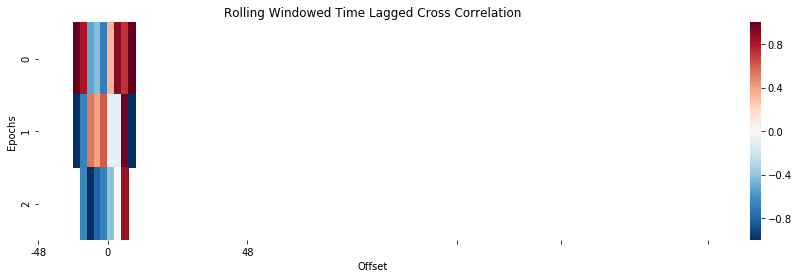

In [19]:
# Rolling window time lagged cross correlation
seconds = 3
fps = 3
window_size = 6 #samples
t_start = 0
t_end = t_start + window_size
step_size = 36
rss=[]


while t_end < 96:
    
    d1 = c1['nr_people'].reset_index(drop=True)
    d2 = c2['nr_people'].reset_index(drop=True)
    print(len(d2))
    d1 = d1.iloc[t_start:t_end]
    d2 = d2.reset_index(drop=True).iloc[t_start:t_end]
    
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(15,4))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,95], xlabel='Offset',ylabel='Epochs')
ax.set_xticks([0, 10, 30, 60, 75, 96])
ax.set_xticklabels([-48, 0, 48]);